In [1]:
# Most Basic
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import math
from os import path
import sys
from datetime import datetime
from scipy.stats import norm
from scipy.linalg import block_diag
import scipy.stats as ss
import copy
import warnings
warnings.simplefilter('error')
import datetime

# Filter Specific Functionalities
from filterpy.kalman import UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import MerweScaledSigmaPoints

# Gradient Based
import autograd.numpy as a_np
import autograd.scipy.stats as a_ss
from autograd import grad, multigrad_dict, elementwise_grad, jacobian

# Self Defined functions5
from DataMaker_New import dataCleaner_new
from ESN import EchoState
from Loss import loss

In [2]:
columns = ["date","exdate","strike_price","best_bid","best_offer","volume","impl_volatility"]
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2019, 12, 31)
train_valid_split = 0.936
valid_test_split = 0.94
u_dim = 5
topK = 5
cleaner = dataCleaner_new(columns, u_dim, topK, start, end, train_valid_split, valid_test_split)
return_dict, price_dict = cleaner.make_return_price()
risk_dict = cleaner.make_risk()
train_data, valid_data, test_data = cleaner.make_final_data(price_dict, return_dict, risk_dict)
num_train_day, num_train_obs = cleaner.get_train_num()
num_valid_day, num_valid_obs = cleaner.get_valid_num()
num_test_day, num_test_obs = cleaner.get_test_num()

# train_data[np.datetime64('2019-01-02T00:00:00.000000000')]

Attached 351 days of train data
Attached 1755 train option observations
Attached 1 days of validation data
Attached 5 validation option observations
Attached 23 days of test data
Attached 115 test option observations


In [3]:
# Define transition Dynamics
# Positional requirement, no real effect, will be replaced by ESN and BS defined further down
def fx(x, dt):
    return x*dt
def hx(x):
    return x

def sigmoid(x):
    return np.divide(1, 1+np.exp(-x))


def ESNf(inner_state, dt, **fx_args):
    """
    :params inner_state [theta_t, G, G_in, b]
    
    **fx_args
    :G_idx    start idx of G
    :G_in_idx start idx of G_in
    :b_idx    start idx of b
    :params u_quad_now u_t^2
    """
    G_idx = fx_args["G_idx"]
    G_in_idx = fx_args["G_in_idx"]
    b_idx = fx_args["b_idx"]
    u_quad_now = fx_args["u_quad_now"].reshape([-1, 1])
    
   
    theta_now = inner_state[: G_idx].reshape([-1,1])
    G_flat = inner_state[G_idx : G_in_idx]
    G_in_flat = inner_state[G_in_idx : b_idx] 
    
    theta_dim = int(math.sqrt(len(G_flat)))
    u_dim = int(len(G_in_flat) / theta_dim)
    
    
    G = G_flat.reshape([theta_dim, theta_dim])
    G_in = G_in_flat.reshape([theta_dim, u_dim])
    b = inner_state[b_idx:].reshape([-1,1])
    
    
    theta_next = sigmoid(np.matmul(G, theta_now) + np.matmul(G_in, u_quad_now) + b)
    
    
    next_state = np.concatenate((theta_next.flatten(), G.flatten(), G_in.flatten(), b.flatten()))
    
    return next_state
    

def BSf(inner_state_t, **hx_args):
    """
    :params theta_t current state vector
    
    **hx_args
    :G_idx    start idx of G
    :G_in_idx start idx of G_in
    :b_idx    start idx of b
    
    :params p_t current asset price
    :params r_t current asset price
    :params K_t strike price, 1d vector
    :params T_t maturity time, 1d vector
    """
    G_idx = hx_args["G_idx"]
    G_in_idx = hx_args["G_in_idx"]
    b_idx = hx_args["b_idx"]
    
    p_t = hx_args["p_t"]
    r_t = hx_args["r_t"]
    K_t = hx_args["K_t"]
    T_t = hx_args["T_t"]
    
    theta_t = inner_state_t[: G_idx].reshape([-1,1])
    G_flat = inner_state_t[G_idx : G_in_idx]
    G_in_flat = inner_state_t[G_in_idx : b_idx] 

    
    theta_dim = int(math.sqrt(len(G_flat)))
    u_dim = int(len(G_in_flat) / theta_dim)
    
    G = G_flat.reshape([theta_dim, theta_dim])
    G_in = G_in_flat.reshape([theta_dim, u_dim])
    b = inner_state_t[b_idx:].reshape([-1,1])
    
    
    volatility_std = np.average(theta_t)
    volatility_var = np.power(volatility_std, 2)
    
    dividor = np.sqrt(volatility_var * T_t)
    d_pls = (np.log(p_t/K_t) + np.multiply(r_t+volatility_var/2, T_t)) / dividor
    d_mns = (np.log(p_t/K_t) + np.multiply(r_t-volatility_var/2, T_t)) / dividor
    y_t = np.multiply(p_t, norm.cdf(d_pls)) - np.multiply(np.multiply(K_t, np.exp(-r_t*T_t)), norm.cdf(d_mns))
    return y_t

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)


# 睡觉专区

In [4]:
np.random.seed(1234)
gradient = grad(loss)
num_iters = 10


forward_k = 20

error_for_all_theta_dim = []

for theta_dim in np.arange(8, 9, 1):
    
    
    G_idx = theta_dim
    G_in_idx = G_idx + theta_dim**2
    b_idx = G_in_idx + u_dim*theta_dim

    
    print("theta_dim = {}".format(theta_dim))
    connectivity = 0.4
    spectral_radius = 0.98
    bday_p_year = 252
    bias = -2

    v_scale = 100.0
    target_var = 1e-6
    chi_mu = math.sqrt(2)* math.gamma((theta_dim+1)/2) / math.gamma(theta_dim/2)
    W_scale = target_var+chi_mu

    # initialize ESN dynamics
    ESN = EchoState(theta_dim, u_dim, connectivity, spectral_radius, bias)
    total_dim = ESN.theta_dim + theta_dim**2 + u_dim*theta_dim + theta_dim
    W = np.eye(total_dim)*W_scale
    v = v_scale

    last_avg_error = 100
    best_itr = 0
    best_train_error = 100
    best_train_itr = 0
    
    dt=1
    points = MerweScaledSigmaPoints(total_dim, alpha=.001, beta=2., kappa=0)
    ukf = UnscentedKalmanFilter(dim_x=total_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)
    initial_theta = np.ones(ESN.theta_dim)* 0.1
    initial_state = np.concatenate((initial_theta, (ESN.G).flatten(), (ESN.G_in).flatten(), (ESN.b).flatten()))
    ukf.x = initial_state # initial state
    ukf.P *= 0.01 # initial uncertainty
    ukf.R = np.diag([v]*topK) # 1 standard
    ukf.Q = W
    
    for forward_backward_itr in range(num_iters):
        ms = [ukf.x.copy()]
        Cs = [ukf.P.copy()]
        u_quad_s = []
        ps = []
        rs = []
        ys = []
        Ks = []
        us = []
        Ts = []

        all_days = sorted(list(train_data.keys()))
        for day in all_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = train_data[day][1] 
            u_t = train_data[day][2].reshape([-1]) * math.sqrt(bday_p_year)
            p_t = train_data[day][3]

            ## Option wise data
            y_t = train_data[day][0]["spotclose"].values
            K_t = train_data[day][0]["strike_price"].values
            today = [d.date() for d in train_data[day][0]["date"]]
            expireday = [d.date() for d in train_data[day][0]["exdate"]]
            T_t = np.busday_count(today, expireday) / bday_p_year


            ukf.predict(fx = ESNf, 
                        G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                        u_quad_now=np.power(u_t,2))
            ukf.update(y_t, hx=BSf, 
                       G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                       p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
            ms.append(ukf.x_post.copy())
            Cs.append(ukf.P_post.copy())
            u_quad_s.append(np.power(u_t,2))
            us.append(u_t)
            ps.append(p_t)
            rs.append(r_t)
            ys.append(y_t)
            Ks.append(K_t)
            Ts.append(T_t)

        ms = np.array(ms)
        Cs = np.array(Cs)
        ms_s, Cs_s = ms, Cs
        ms_s, Cs_s, _, cvs_s = ukf.rts_smoother_alternative(ms, Cs, fx=ESNf,
                                                            G_idx=G_idx,
                                                            G_in_idx=G_in_idx,
                                                            b_idx=b_idx,
                                                            u_quad_s=u_quad_s)
        
        num_to_average = 10
        theta_last_m = ms_s[-1][:G_idx]
        theta_last_C = Cs_s[-1][:G_idx, :G_idx]
        weight_last_m = np.array(ms_s[-num_to_average:])[:, G_idx:]
        weight_last_C = np.array(Cs_s[-num_to_average:])[:, G_idx:, G_idx:]
        avg_weight_last_m = np.average(weight_last_m, axis=0)
        avg_weight_last_C = np.average(weight_last_C, axis=0)
        ukf.x = np.concatenate((theta_last_m, avg_weight_last_m))  # initial state
        ukf.P = block_diag(theta_last_C, avg_weight_last_C)  # initial uncertainty        
        
    ################################################################### Validation Performance
        valid_errors = []

        all_valid_days = sorted(list(valid_data.keys()))
        for day in all_valid_days:
            # get observable data
            ## Stock Wise and market wise data
            r_t = valid_data[day][1]
            u_t = valid_data[day][2].reshape([-1]) * math.sqrt(bday_p_year)
            p_t = valid_data[day][3]

            ## Option wise data
            y_t = valid_data[day][0]["spotclose"].values
            K_t = valid_data[day][0]["strike_price"].values
            today = [d.date() for d in valid_data[day][0]["date"]]
            expireday = [d.date() for d in valid_data[day][0]["exdate"]]
            T_t = np.busday_count(today, expireday) / bday_p_year

            ukf.predict(fx = ESNf, 
                        G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                        u_quad_now=np.power(u_t,2))
            pred_price = BSf(ukf.x_prior, 
                             G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                             p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)

            error = np.average(np.abs(y_t-pred_price) /y_t)
            valid_errors.append(error)

            ukf.update(y_t, hx=BSf,
                       G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx,
                       p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)

        avg_valid_error = np.average(valid_errors) 

    ################################################################### Testing Performance

        # forward K step prediction
        k_step_test_error = []

        for k in range(1, min(forward_k+1, num_test_day+1)):

            test_errors = []


            all_test_days = sorted(list(test_data.keys()))

            # For loop for base shift, shift of last updated ukf timestep
            for idx in range(len(all_test_days) - k):

                ukf_pred = copy.deepcopy(ukf)

                # For loop for k predictions forward
                for shift in range(k) :
                    # get observable data
                    ## Stock Wise and market wise data
                    r_t = test_data[all_test_days[idx+shift]][1] 
                    u_t = test_data[all_test_days[idx+shift]][2].reshape([-1]) * math.sqrt(bday_p_year)
                    p_t = test_data[all_test_days[idx+shift]][3]

                    ## Option wise data
                    y_t = test_data[all_test_days[idx+shift]][0]["spotclose"].values
                    K_t = test_data[all_test_days[idx+shift]][0]["strike_price"].values
                    today = [d.date() for d in test_data[all_test_days[idx+shift]][0]["date"]]
                    expireday = [d.date() for d in test_data[all_test_days[idx+shift]][0]["exdate"]]
                    T_t = np.busday_count(today, expireday) / bday_p_year

                    ukf_pred.predict(fx = ESNf, 
                                     G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx, 
                                     u_quad_now=np.power(u_t,2))



                pred_price = BSf(ukf_pred.x_prior, 
                                 G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx,
                                 p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)
                error = np.average(np.abs(y_t-pred_price) /y_t)
                test_errors.append(error)


                # shift base one step forward
                r_t = test_data[all_test_days[idx]][1]
                u_t = test_data[all_test_days[idx]][2].reshape([-1]) * math.sqrt(bday_p_year)
                p_t = test_data[all_test_days[idx]][3]

                ## Option wise data
                y_t = test_data[all_test_days[idx]][0]["spotclose"].values
                K_t = test_data[all_test_days[idx]][0]["strike_price"].values
                today = [d.date() for d in test_data[all_test_days[idx]][0]["date"]]
                expireday = [d.date() for d in test_data[all_test_days[idx]][0]["exdate"]]
                T_t = np.busday_count(today, expireday) / bday_p_year

                ukf.predict(fx = ESNf, 
                            G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx,
                            u_quad_now=np.power(u_t,2))
                ukf.update(y_t, hx=BSf, 
                           G_idx=G_idx, G_in_idx=G_in_idx, b_idx=b_idx,
                           p_t=p_t, r_t=r_t, K_t=K_t, T_t=T_t)

            if test_errors != []:
                avg_test_error = np.average(test_errors)
                k_step_test_error.append(avg_test_error)
            else:
                pass
            
        
        print("B&F {:2} | Valid Error {:.4f} | Test 1-Error {:.4f} | Test Max-Error {:.4f} ".format(forward_backward_itr,
                                                                                                    avg_valid_error, 
                                                                                                    k_step_test_error[0],
                                                                                                    k_step_test_error[-1]))
            
        ukf = UnscentedKalmanFilter(dim_x=total_dim, dim_z=topK, dt=1, fx=fx, hx=hx, points=points)

#=============================== Circular Online Training ================================
#
        theta_first_m = ms_s[0][:G_idx]
        weight_last_m = ms_s[-1][G_idx:]
        theta_first_C = Cs_s[0][:G_idx, :G_idx]
        weight_last_C = Cs_s[-1][G_idx:, G_idx:]
        ukf.x = np.concatenate((theta_first_m, avg_weight_last_m))  # initial state
        ukf.P = block_diag(theta_first_C, avg_weight_last_C)  # initial uncertainty
#
#=============================== In-order Online Training ================================
#
#         ukf.x = ms_s[0]  # np.concatenate((theta_first_m, weight_last_m))  # initial state
#         ukf.P = Cs_s[0]  # block_diag(theta_first_C, weight_last_C)  # initial uncertainty
#
#=============================== Averages Online Training ================================
#
        

#
#         print(ukf.x[b_idx:])
    
    error_for_all_theta_dim.append(k_step_test_error)
    
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

theta_dim = 8
B&F  0 | Valid Error 1.1216 | Test 1-Error 1.8987 | Test Max-Error 10.6101 
-212.48244611918926
-796.9446294993601
False


LinAlgError: 27-th leading minor of the array is not positive definite

# Plot Prediction error vs forward step & Volatility trajectory  

 1-step error 0.9036
 2-step error 0.9030
 3-step error 0.8992
 4-step error 0.8927
 5-step error 0.8915
 6-step error 0.8876
 7-step error 0.8875
 8-step error 0.8913
 9-step error 0.8857
10-step error 0.8763
11-step error 0.8659
12-step error 0.8561
13-step error 0.8466
14-step error 0.8563
15-step error 0.8468
16-step error 0.8499
17-step error 0.8414
18-step error 0.8476
19-step error 0.9295
20-step error 0.9375
AVERAGE error 0.8798


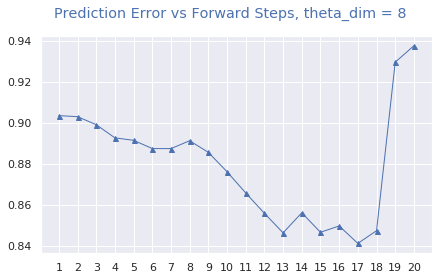

In [18]:
warnings.simplefilter("ignore")

for k in range(len(error_for_all_theta_dim)):

    sns.set()
    fig = plt.figure(figsize=(7, 4))
    fig.suptitle('Prediction Error vs Forward Steps, theta_dim = {}'.format(k+theta_dim), color='C0')
    

    # forward steps
    xlabel = list(range(len(k_step_test_error)+1))
    plt.xticks(xlabel)
    show = error_for_all_theta_dim[k]
    plt.plot([i+1 for i in range(len(k_step_test_error))], show, marker='^', markersize= 5, linewidth=1)
    fig.show()
    
    for i, p in enumerate(show):
        print("{:2}-step error {:.4f}".format(i+1, p))
        
    print("AVERAGE error {:.4f}".format(np.average(show)))
    

# Test Implied Volatility

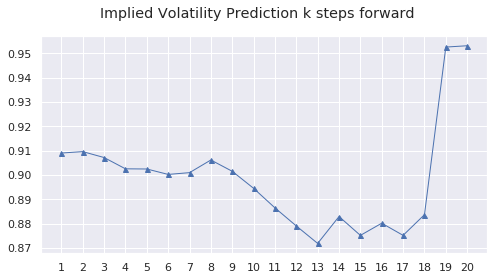

In [176]:
base_date = list(valid_data.keys())[-1]
base_date_vol = np.average(valid_data[list(valid_data.keys())[-1]][0]["impl_volatility"].values) / bday_p_year

test_days = list(test_data.keys())
test_error_traj_imp_vol = []
for k in range(1, min(forward_k+1, num_test_day+1)):
    k_step_test_error_imp_vol = []
    for idx in range(k-1, num_test_day):
        pred_date = test_days[idx]
        pred_date_p = test_data[pred_date][3]
        pred_date_r = test_data[pred_date][1] / bday_p_year
        pred_date_K = test_data[pred_date][0]["strike_price"].values
        today = [d.date() for d in test_data[pred_date][0]["date"]]
        expireday = [d.date() for d in test_data[pred_date][0]["exdate"]]
        pred_date_T = np.busday_count(today, expireday)
        pred_date_y = test_data[pred_date][0]["spotclose"].values

        pred_price_imp_vol = BSf(base_date_vol, 
                                 p_t=pred_date_p, 
                                 r_t=pred_date_r, 
                                 K_t=pred_date_K, 
                                 T_t=pred_date_T)
        pred_error_imp_vol = np.average(np.abs(pred_price_imp_vol-pred_date_y) / pred_date_y)
        k_step_test_error_imp_vol.append(pred_error_imp_vol)

        base_date = test_days[idx-k+1]
        base_date_vol = np.average(valid_data[list(valid_data.keys())[-1]][0]["impl_volatility"].values) / bday_p_year

    test_error_traj_imp_vol.append(np.average(k_step_test_error_imp_vol))

fig = plt.figure(figsize=(8,4))
fig.suptitle("Implied Volatility Prediction k steps forward")
plt.xticks(xlabel)
plt.plot([_+1 for _ in range(forward_k)], test_error_traj_imp_vol, marker ='^', markersize=5, linewidth=1)
fig.show()

In [162]:
train_data[np.datetime64('2019-01-02T00:00:00.000000000')]

[              date     exdate  strike_price  best_bid  best_offer  volume  \
 7824298 2019-01-02 2019-06-21        3050.0      3.40         3.7   30005   
 7824308 2019-01-02 2019-06-21        3300.0      0.75         1.0   30005   
 7823256 2019-01-02 2019-01-18        2570.0     14.50        15.3   22363   
 7823260 2019-01-02 2019-01-18        2590.0      9.20         9.8   19735   
 7825956 2019-01-02 2019-01-11        2525.0     23.40        24.0   19555   
 
          impl_volatility  spotclose  
 7824298         0.149985      3.550  
 7824308         0.163895      0.875  
 7823256         0.180783     14.900  
 7823260         0.174487      9.500  
 7825956         0.192232     23.700  ,
 0.0279388,
 array([ 8.64007027e-05, -1.53957145e-02, -1.57721063e-02, -2.05882284e-02,
        -2.71122542e-02,  4.95937426e-02,  8.56268080e-03, -1.24158255e-03,
         8.49248436e-03,  1.26849667e-03]),
 2510.030029]